# CV home task: getTilePixel

###### By: Nimrod Dvir

In [1]:
import cv2
import matplotlib.pyplot as plt
from types import SimpleNamespace
from math import floor

The way I imagine the architecture of this system is that the 'Local Storage' is a folder, where all orthophotos files are saved by the file name 'TILEij', where (i,j) are the coordinates (or indices) of the tile on the grid that covers all the data set's mosaic of orthophotos (and starts with (0,0) on the top-left square). There is no overlapping between the tiles!

I find it the most convenient and straightforward way to access the orthophotos files. Other ways, e.g., with a mapping dictionary or a matrix are also fairly easy to apply.

To enable a checkup for this code without a local storage of orthophotos, I have creatd a folder named 'Local Storage' with only one image file, 'TILE00' (of course, there are no real relations between the image and the following example coordinates...).

(The image is available for downloading at this link: https://drive.google.com/open?id=1FcPtyW4DKnANTUi6Fb6bzhHR6V3_so6D)

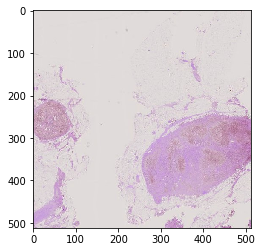

In [2]:
# And just for the perception of this image:
img = cv2.imread('C:/Users/dvirn/Documents/Data Science/Local Storage/TILE00.jpg')
plt.imshow(img)
plt.show()

The map's parameters are given in a text file, located in the same folder, in a format I assume can be a standard for every similar storage. These parameters are (allowing the more general cases of not square map, image files and pixels):
1. resWidth, resHeight = Resolution (Number of pixels in each tile is [resWidth X resHeight]).
2. topLeftLong, topLeftLat = Dataset's top-left WGS-84 coordinates [Decimal Degrees].
3. pixelWidth, pixelHeight = Data set's scale (or "ground resolution") [degrees/pixel].
4. xTilesNum , yTilesNum = Number of tiles in the data set.

The parmaters are drawn into a dictionary, and by that are available when using the theme function. Again, other methods are possible (for example, pandas' read_csv, or python strings' manipulations), but I find this one the most comfortable and elegant.

(This sample text file is available for downloading at this link: https://drive.google.com/open?id=1Z2pFNbwdtWw8KnmbAdGNujctK2UY5tS1)

In [3]:
file = 'C:/Users/dvirn/Documents/Data Science/Local Storage/Map Info.txt'
d = { line.split()[0] : float(line.split()[1]) for line in open(file) }

# For introduction with the example parameters (all are arbitrary):
for key,value in d.items():
    print(key, value)
    
# For conveniency later, let's provide attribute access for these parameters:
p = SimpleNamespace(**d)

resWidth 512.0
resHeight 512.0
topLeftLong 35.0
topLeftLat 33.0
pixelWidth 1e-05
pixelHeight 1e-05
xTilesNum 100.0
yTilesNum 100.0


The algoritm to find the pixel's value for a given geographical pair coordinates:
1. Check if the input is valid, i.e., a proper decimal degree Longitude/Latitude coordinates.
2. Convert form Long/Lat to pixel-coordinates on the data set's mosaic, i.e., number of pixels the input coordinates are far, in both axes, from the top-left known coordinates.
3. Calculate the compatible tile's indices.
4. Check if the potential tile is in the dataset (indices are in the given range of tiles).
    - If Yes: Draw the matching file path from the local storage.
    - If No: Call another function that can draw the matching file path from an external server (this assumes that the tiles' grid continues in the same manner outside the local storage scope (in the server)).
    * Remark: It is also possible to check if the given coordinates are in the dataset as the second step (instead of the fourth), by calculating the data set's dimensions in degrees (mapWidth = xTilesNum \* resWidth \* pixelWidth, and similar for the height). However, in the current data structure and assumptions, this calculation does not preclude any other steps, and is redundant when applying the algorithm as I've chosen to.
5. Read the orthophoto file.
6. Convert the "global" pixel-coordinates (obtained at step 2) to "local" pixel-coordinates (in the tile).
7. Return the pixel's value.

The implementation of the function:

In [4]:
def getTilePixel(longitude, latitude):
    
    """ Input:   A geographical WGS84 D.D coordinate as two float variables.
        Output:  The corresponding pixel's BGR value.
        Remarks: This function assumes all the needed parameters have been loaded,
                 and are global variables in the SimpleNamespace object 'p'.
    """
    
    # Input validity:
    if type(longitude) != float or longitude < -180 or longitude > 180:
        raise ValueError('longitude must be a float between -180 and 180')
    if type(latitude) != float or latitude < -85.05112878 or latitude > 85.05112878:
        raise ValueError('latitude must be a float between -85.05112878 and 85.05112878')
    # "Adhering to these values avoids a singularity at the poles, and it ensures that the projected map is a squared shape."
    
    # Number of pixels to move from the top-left corner of the data set:
    x = (longitude - p.topLeftLong)/p.pixelWidth
    y = (p.topLeftLat - latitude)/p.pixelHeight
    
    # Finding the relevant tile's index (where (0,0) is the top-left tile):
    i = floor(x / p.resWidth)
    j = floor(y / p.resHeight)
    
    # Checking if the required tile for the input's coordinates is in the local storage, and draw the compatible file's path:
    if (0 <= i <= p.xTilesNum) and (0 <= j <= p.yTilesNum):
        tile = 'C:/Users/dvirn/Documents/Data Science/Local Storage/TILE'+str(i)+str(j)+'.jpg'
    else:
        tile = getTileFromServer(longitude, latitude)    
   
    # Loading the relevant tile's image file:   
    img = cv2.imread(tile)

    # Number of pixels to move from the top-left corner of the tile:
    x = int(x - i * p.resWidth)
    y = int(y - j * p.resHeight)
    
    return img[x,y]

Here is an example run of the function to ensure accomplishment: 

In [5]:
# An examination of the code (with coordinates that fall in the first tile...) 
getTilePixel(35.003, 32.997)

array([205, 167, 215], dtype=uint8)